In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score,classification_report
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout, BatchNormalization, Lambda, Input, InputLayer, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPooling2D, concatenate
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import CSVLogger
import random
import numpy as np

In [14]:
DATA_DIR = 'data'
IMAGE_DIR = f'../{DATA_DIR}/dataset'
model_type = 'siamese'

image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2
    )

data_train = image_generator.flow_from_directory(
    IMAGE_DIR,
    target_size=(128,128),
    batch_size=256,
    class_mode='categorical',
    shuffle=True,
    subset = 'training'   
)

data_val = image_generator.flow_from_directory(
    IMAGE_DIR,
    target_size=(128,128),
    batch_size=256,
    class_mode='categorical',
    shuffle=True,
    subset = 'validation'   
)

N_CLASSES = data_train.num_classes
IMSIZE = (128,128,3)

Found 4146 images belonging to 5 classes.
Found 1034 images belonging to 5 classes.


In [59]:
class Pair(object):
    """
    def make_pairs(self, num_classes):
    """
    def __init__(self, data):
        _x, _y = data
        self._x, self._y = np.array(_x), np.array(_y)

    def decode_img(self, img):
        """
        Decode the image from the path.
        """
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img

    def get_pairs(self):
        """
        Get the pairs of images and labels.
        """
        _, _y = self._x, self._y
        pairs, labels = self.make_pairs(len(np.unique(_y)))
        element_1 = tf.data.Dataset.from_tensor_slices(pairs[:, 0])
        element_2 = tf.data.Dataset.from_tensor_slices(pairs[:, 1])
        labels = tf.data.Dataset.from_tensor_slices(labels)
        return (element_1, element_2, labels)

    def make_pairs(self, num_classes):
        """
        Make pairs of images and labels.
        """
        _x, _y = self._x, self._y
        digit_indices = [np.where(_y == i)[0] for i in range(num_classes)]

        pairs = list()
        labels = list()

        for idx_1,_ in enumerate(_x):
            x_1 = _x[idx_1]
            label1 = _y[idx_1]
            idx_2 = random.choice(digit_indices[label1])
            x_2 = _x[idx_2]

            labels += list([1])
            pairs += [[x_1, x_2]]

            label2 = random.randint(0, num_classes-1)
            while label2 == label1:
                label2 = random.randint(0, num_classes-1)

            idx_2 = random.choice(digit_indices[label2])
            x_2 = _x[idx_2]

            labels += list([0])
            pairs += [[x_1, x_2]]
        print(np.unique(labels, return_counts=True))
        print(pairs)
        print(labels)
        return np.array(pairs), np.array(labels)

In [60]:
images = []
labels = []
classes = os.listdir(IMAGE_DIR)
for image_class in classes:
    images_paths = os.listdir(f'{IMAGE_DIR}/{image_class}')
    for image_path in images_paths:
        images.append(f'{IMAGE_DIR}/{image_class}/{image_path}')
        labels.append(int(image_class))
def decode_img(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (128,128))
    return img/255

pair_generator = Pair((images, labels))
element_set_1, element_set_2, pair_labels =  pair_generator.get_pairs()

# Evaluate the dataset

element_set_1 = element_set_1.map(decode_img)
element_set_2 = element_set_2.map(decode_img)

if model_type == 'siamese':
    data = tf.data.Dataset.zip(((element_set_1, element_set_2), pair_labels))
    data = data.shuffle(3).batch(128)

(array([0, 1]), array([5180, 5180]))
[['../data/dataset/1/front_img382.jpg', '../data/dataset/1/front_img729.jpg'], ['../data/dataset/1/front_img382.jpg', '../data/dataset/0/back_img259.jpg'], ['../data/dataset/1/front_img979.jpg', '../data/dataset/1/front_img62.jpg'], ['../data/dataset/1/front_img979.jpg', '../data/dataset/3/right_img402.jpg'], ['../data/dataset/1/front_img100.jpg', '../data/dataset/1/front_img542.jpg'], ['../data/dataset/1/front_img100.jpg', '../data/dataset/0/back_img355.jpg'], ['../data/dataset/1/front_img471.jpg', '../data/dataset/1/front_img625.jpg'], ['../data/dataset/1/front_img471.jpg', '../data/dataset/4/stop_img555.jpg'], ['../data/dataset/1/front_img995.jpg', '../data/dataset/1/front_img606.jpg'], ['../data/dataset/1/front_img995.jpg', '../data/dataset/3/right_img279.jpg'], ['../data/dataset/1/front_img809.jpg', '../data/dataset/1/front_img219.jpg'], ['../data/dataset/1/front_img809.jpg', '../data/dataset/3/right_img419.jpg'], ['../data/dataset/1/front_img3

In [49]:
pair_labels

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [43]:
def euclidean_distance(_v):
    """
    Computes the euclidean distance between two vectors."""
    _x, _y = _v
    sum_square = K.sum(K.square(_x - _y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def cosine_distance(_v):
    """
    Computes the cosine distance between two vectors.
    """

    _x, _y = _v
    _x = tf.nn.l2_normalize(_x, axis=1)
    _y = tf.nn.l2_normalize(_y, axis=1)
    return tf.constant([1.],shape=(1,1)) -K.sum(_x * _y, axis=1, keepdims=True)

def dist_output_shape(shapes):
    """
    Computes the output shape of the euclidean distance layer.
    """
    shape1, _ = shapes
    return (shape1[0], 1)

def contrastive_loss(y_original, y_pred):
    """
    Contrastive loss function.
    """
    y_pred = tf.cast(y_pred, tf.float32)
    y_original = tf.cast(y_original, tf.float32)
    sqaure_pred = K.square(y_pred)
    margin = 1.0
    margin_square = K.square(K.maximum(0.0, margin - y_pred))
    return K.mean(y_original * sqaure_pred + (1.0 - y_original) * margin_square)

def finetuned_resnet(include_top=False):
    model = Sequential()
    model.add(InputLayer(input_shape=IMSIZE))
    model.add(Conv2D(64,(5,5),activation='relu',strides=(2,2),padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(2,2),padding='same'))

    model.add(Conv2D(64,(1,1),activation='relu',padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(128,(1,1),activation='relu',padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256,(1,1),activation='relu',padding='same'))
    model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
    model.add(Conv2D(512,(3,3),activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(2,2)))

    # base_model = ResNet50(include_top=include_top,input_shape=IMSIZE)
    # for layer in base_model.layers:
    #     layer.trainable = False

    base_model = model


    if model_type == 'classifier':
        x = base_model.output
        x = Flatten()(x)
        x = BatchNormalization()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)
        if not include_top:
            x = Dense(N_CLASSES, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=x)
        model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

    if model_type == 'siamese':
        input_tensor = Input(shape=IMSIZE)
        input_base = base_model.input
        output_base = base_model.output
        base = Model(inputs=input_base, outputs=output_base)
        base.trainable =  True
        x = base(input_tensor)
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        out = Dense(128)(x)
        # out = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)

        embedding = Model(input_tensor, out)

        input_1 = Input(shape=IMSIZE)
        input_2 = Input(shape=IMSIZE)

        embedding_1 = embedding(input_1)
        embedding_2 = embedding(input_2)

        distance = Lambda(
            cosine_distance,
            output_shape=dist_output_shape)([embedding_1, embedding_2])
        model = Model([input_1, input_2], distance)
        loss = contrastive_loss
        model.compile(loss=loss, optimizer="rmsprop", metrics=['accuracy'])

    return model

In [44]:
resnet_model = finetuned_resnet()

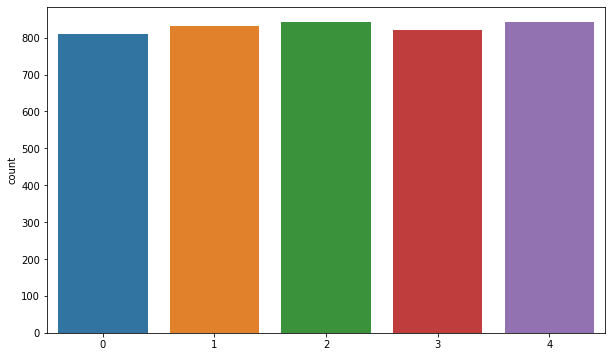

In [45]:
y = data_train.labels

plt.figure("countplot",figsize=(10,6))
sns.countplot(x=y.flatten())
plt.show()

In [46]:

csv_log = CSVLogger(
    "logs/"+
    str(model_type)+
    str("ResNet50")+
    "-training.log",
    separator=",",
    append=True
    )



resnet_model.optimizer.lr = 0.0001
resnet_model.optimizer.momentum = 0.9
with tf.device('/gpu:0'):
    if model_type == 'classifier':
        history = resnet_model.fit(data_train, epochs=10, validation_data=data_val)
    if model_type == 'siamese':
        history = resnet_model.fit(data, epochs=100, callbacks=[csv_log])

Epoch 1/100
81/81 [==============================] - 20s 229ms/step - loss: 0.2624 - accuracy: 0.4968
Epoch 2/100
81/81 [==============================] - 19s 232ms/step - loss: 0.2592 - accuracy: 0.4957
Epoch 3/100
81/81 [==============================] - 19s 234ms/step - loss: 0.2597 - accuracy: 0.4983
Epoch 4/100
81/81 [==============================] - 19s 235ms/step - loss: 0.2593 - accuracy: 0.5045
Epoch 5/100
81/81 [==============================] - 19s 236ms/step - loss: 0.2589 - accuracy: 0.5003
Epoch 6/100
81/81 [==============================] - 19s 234ms/step - loss: 0.2571 - accuracy: 0.5012
Epoch 7/100
81/81 [==============================] - 19s 235ms/step - loss: 0.2590 - accuracy: 0.5041
Epoch 8/100
11/81 [===>..........................] - ETA: 16s - loss: 0.2582 - accuracy: 0.5085

KeyboardInterrupt: 

In [ ]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

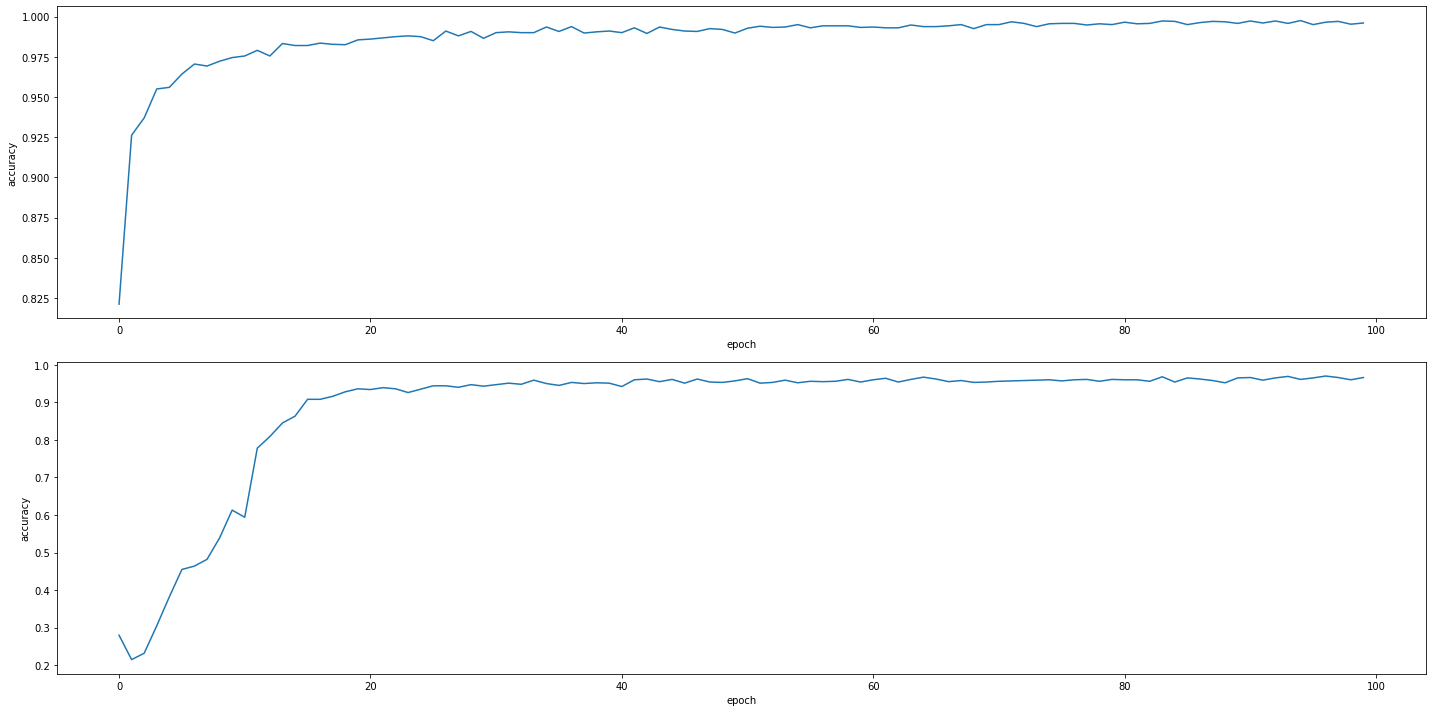

In [ ]:
plt.figure("Model Metrics",(20,10))
plt.title('model accuracy')
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(2,1,2)
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()


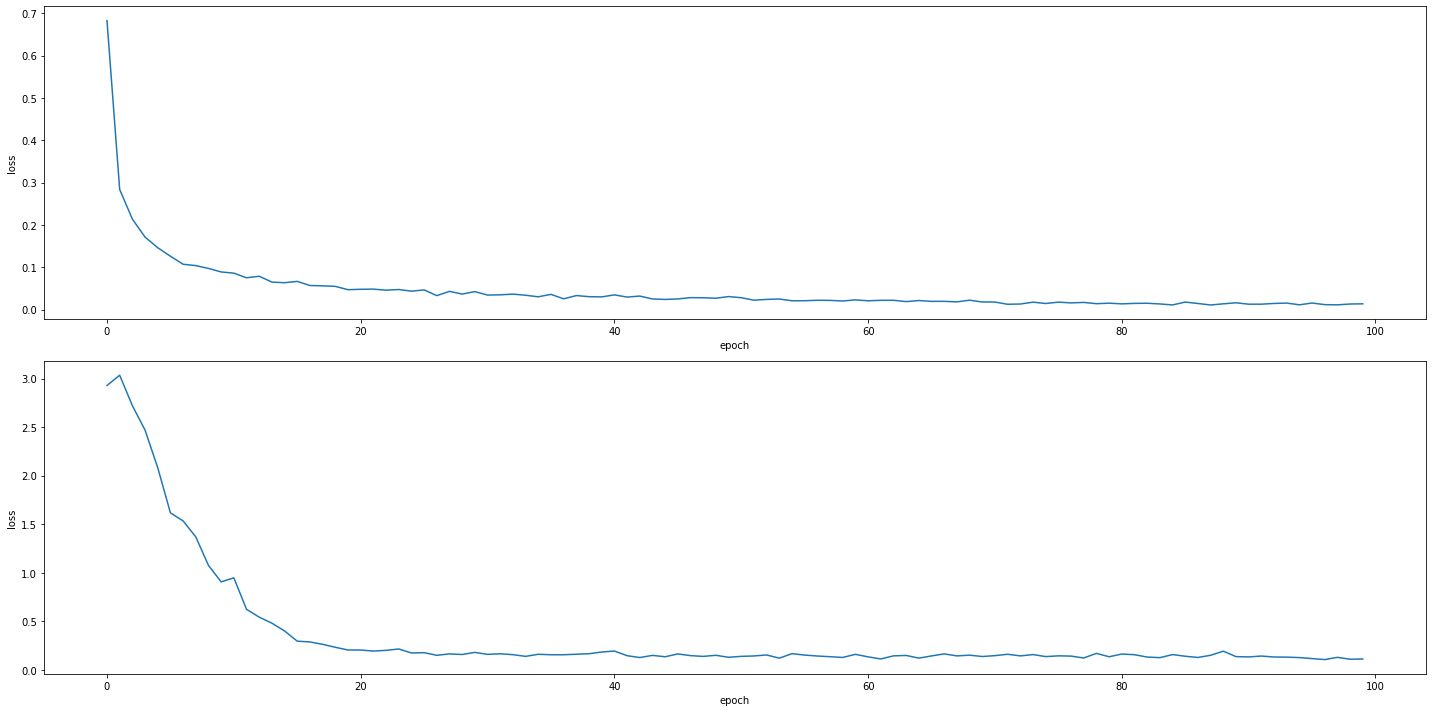

In [ ]:
plt.figure("Model Metrics",(20,10))
plt.title('model accuracy')
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(2,1,2)
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [ ]:
resnet_model.save('../model/saved/resnet_model.h5')

In [ ]:
a = open("../movement", 'r', encoding="utf-8").read()